In [22]:
#%%capture
from pyicecake import pyicecake
import types
import collections
import numpy as np
from random import shuffle
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import PIL
from PIL import Image
import cupy as cp
from timeit import default_timer as timer
from matplotlib.pyplot import imshow

In [2]:
import sys
sys.path.append('/home/lwangay/workspace/FastGC-icecake/build/lib')
import pjcache as JC

In [3]:
jc = JC.JPEGCacheClient("127.0.0.1", 8090)

filenames = ["/tmp/test_7687.jpeg", "/tmp/test_mouse_rst_1b.jpeg"]*1000
for f in filenames[:10]:
    print(jc.put(f))

0
0
0
0
0
0
0
0
0
0


In [4]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline
def show_all_imgs(imgs):
    _, axs = plt.subplots(5, 4, figsize=(12, 12))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        ax.imshow(img)
    plt.show()

In [5]:
# import shutil,os
# for f in filenames:
#     os.makedirs(os.path.dirname('/mnt/optane-ssd/lipeng/imagenet/5000/'+f), exist_ok=True)
#     shutil.copy('/mnt/optane-ssd/lipeng/imagenet/'+f, '/mnt/optane-ssd/lipeng/imagenet/5000/'+f) 
    

In [6]:
class ExternalInputIterator(object):
    def __init__(self, batch_size, device_id, num_gpus):
        self.batch_size = batch_size
        self.files = filenames
        # whole data set size
        self.data_set_len = len(self.files) 
        self.n = len(self.files)

    def __iter__(self):
        self.i = 0
        shuffle(self.files)
        return self

    def __next__(self):
        batch = []
        labels = []

        if self.i >= self.n:
            raise StopIteration

        for _ in range(self.batch_size):
            jpeg_filename= self.files[self.i]
            label = '0'
            batch.append(np.frombuffer(jc.get_raw_file(jpeg_filename), dtype = np.uint8))
            labels.append(np.array([label], dtype = np.uint8))
            self.i = (self.i + 1) % self.n
        return (batch, labels)

    @property
    def size(self,):
        return self.data_set_len

    next = __next__


In [7]:
class ExternalInputIteratorFusedRandomCrop(object):
    def __init__(self, batch_size, device_id, num_gpus):
        self.batch_size = batch_size
        self.files = filenames
        # whole data set size
        self.data_set_len = len(self.files) 
        self.n = len(self.files)

    def __iter__(self):
        self.i = 0
        shuffle(self.files)
        return self

    def __next__(self):
        batch = []
        labels = []

        if self.i >= self.n:
            raise StopIteration

        for _ in range(self.batch_size):
            jpeg_filename= self.files[self.i]
            label = '0'
            batch.append(np.frombuffer(jc.get_serialized_header_ROI(jpeg_filename, 0,0,224,224), dtype = np.uint8))
            labels.append(np.array([label], dtype = np.uint8))
            self.i = (self.i + 1) % self.n
        return (batch, labels)

    @property
    def size(self,):
        return self.data_set_len

    next = __next__

In [8]:
class SimplePipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, external_data):
        super(SimplePipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.input = ops.ExternalSource()
        self.input_label = ops.ExternalSource()
        self.decode = ops.ImageDecoderRandomCrop(device = "cpu", output_type = types.RGB)
        self.res = ops.Resize(device="cpu", resize_x=224, resize_y=224)
        self.cast = ops.Cast(device = "gpu",
                             dtype = types.UINT8)
        self.external_data = external_data
        self.iterator = iter(self.external_data)
    def define_graph(self):
        self.jpegs = self.input()
        self.labels = self.input_label()
        images = self.decode(self.jpegs)
        images = self.res(images)
#         output = self.cast(images)
        return (images, self.labels)

    def iter_setup(self):
        try:
            (images, labels) = self.iterator.next()
            self.feed_input(self.jpegs, images)
            self.feed_input(self.labels, labels)
        except StopIteration:
            self.iterator = iter(self.external_data)
            raise StopIteration

In [9]:
class MixedPipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, external_data):
        super(MixedPipeline, self).__init__(batch_size, num_threads, device_id, seed = 12)
        self.input = ops.ExternalSource()
        self.input_label = ops.ExternalSource()
        self.decode = ops.ImageDecoderRandomCrop(device = "mixed")
        self.res = ops.Resize(device="gpu", resize_x=224, resize_y=224)
        self.cast = ops.Cast(device = "gpu",
                             dtype = types.UINT8)
        self.external_data = external_data
        self.iterator = iter(self.external_data)
    def define_graph(self):
        self.jpegs = self.input()
        self.labels = self.input_label()
        images = self.decode(self.jpegs)
        images = self.res(images)
#         output = self.cast(images)
        return (images, self.labels)

    def iter_setup(self):
        try:
            (images, labels) = self.iterator.next()
            self.feed_input(self.jpegs, images)
            self.feed_input(self.labels, labels)
        except StopIteration:
            self.iterator = iter(self.external_data)
            raise StopIteration

In [10]:
import sys
sys.path.append('/home/lwangay/workspace/FastGC-icecake/build/lib')
import pjcache as JC
import nvidia.dali.plugin_manager as plugin_manager
import os
print(os.path.dirname(JC.__file__)+"/libdali_icecake.so")
plugin_manager.load_library(os.path.dirname(JC.__file__)+"/libdali_icecake.so")

/home/lwangay/workspace/FastGC-icecake/build/lib/libdali_icecake.so


In [11]:
class ExternalSourcePipelineGPUJPEG(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, external_data):
        super(ExternalSourcePipelineGPUJPEG, self).__init__(batch_size,
                                      num_threads,
                                      device_id,
                                      seed=12)
        self.input = ops.ExternalSource()
        self.input_label = ops.ExternalSource()
        self.decode = ops.DaliIcecake(device = "mixed")
        self.res = ops.Resize(device="gpu", resize_x=224, resize_y=224)
        self.cast = ops.Cast(device = "gpu",
                             dtype = types.UINT8)
        self.external_data = external_data
        self.iterator = iter(self.external_data)

    def define_graph(self):
        self.jpegs = self.input()
        self.labels = self.input_label()
        images = self.decode(self.jpegs)
        images = self.res(images)
#         output = self.cast(images)
        return (images, self.labels)

    def iter_setup(self):
        try:
            (images, labels) = self.iterator.next()
            self.feed_input(self.jpegs, images)
            self.feed_input(self.labels, labels)
        except StopIteration:
            self.iterator = iter(self.external_data)
            raise StopIteration

In [12]:
nthread = 4

In [32]:
from timeit import default_timer as timer
def speedtest(pipeclass, batch, n_threads, eii = None):
    pipe = None
    if eii is not None:
        pipe = pipeclass(batch, n_threads, 0, eii)
    else:
        pipe = pipeclass(batch, n_threads, 0)
    pipe.build()
    # warmup
    for i in range(5):
        pipe.run()
    # test
    n_test = 500
    t_start = timer()
    for i in range(n_test):
        img = pipe.run()
    t = timer() - t_start
    print("time: {}".format(t))
    print("Speed: {} imgs/s".format((n_test * batch)/t))
    if isinstance(img[0].at(0),np.ndarray):
        imshow(img[0].at(0))
    else:
        cpu_img = img[0].at(0).as_cpu()
        imshow(cpu_img)

In [33]:
batch_size=32

time: 15.6059287909884
Speed: 1025.251378132595 imgs/s


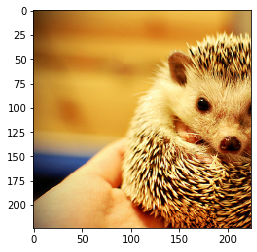

In [34]:
eii = ExternalInputIterator(batch_size, 0, 1)
speedtest(SimplePipeline, batch_size, nthread, eii)

time: 10.156054268125445
Speed: 1575.4149768789293 imgs/s


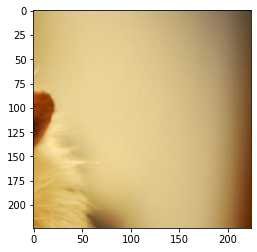

In [35]:
eii = ExternalInputIterator(batch_size, 0, 1)
speedtest(MixedPipeline, batch_size, nthread, eii)

In [36]:
#speedtest(DLTensorPipeline, batch_size, nthread)

time: 2.52334218705073
Speed: 6340.796774257843 imgs/s


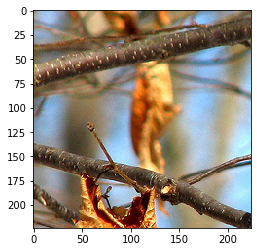

In [37]:
eii = ExternalInputIteratorFusedRandomCrop(batch_size, 0, 1)
speedtest(ExternalSourcePipelineGPUJPEG, batch_size, nthread, eii)